## Temp Dataset - Prophet Task

In [813]:
import pandas as pd
import numpy as np
from random import randrange
from pandas import Series
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [814]:
df = pd.read_csv(r'../../dataset/MLTempDataset.csv',parse_dates=True,index_col='Datetime')
df

,Unnamed: 0,Datetime1,DAYTON_MW
Datetime,,,
2022-01-04 00:00:00,0,0,20.867
2022-01-04 01:00:00,1,1,21.000
2022-01-04 02:00:00,2,2,20.867
2022-01-04 03:00:00,3,3,20.650
2022-01-04 04:00:00,4,4,20.400
...,...,...,...
2022-10-08 23:00:00,6671,19,27.350
2022-10-09 00:00:00,6672,20,26.800
2022-10-09 01:00:00,6673,21,26.450


In [815]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.head()

,Datetime1,DAYTON_MW
Datetime,,
2022-01-04 00:00:00,0,20.867
2022-01-04 01:00:00,1,21.000
2022-01-04 02:00:00,2,20.867
2022-01-04 03:00:00,3,20.650
2022-01-04 04:00:00,4,20.400


In [816]:
# Aggregate data by day to improve prediction
dff = df.resample(rule='D').mean()
dff

,Datetime1,DAYTON_MW
Datetime,,
2022-01-04,10.791667,21.064583
2022-01-05,11.500000,15.375625
2022-01-06,11.500000,19.591000
2022-01-07,11.500000,15.544500
2022-01-08,11.500000,15.779917
...,...,...
2022-10-05,11.500000,25.639750
2022-10-06,11.500000,25.817167
2022-10-07,11.500000,26.361583


### Data Evaluation

Text(0.5, 1.0, 'Room temperature')

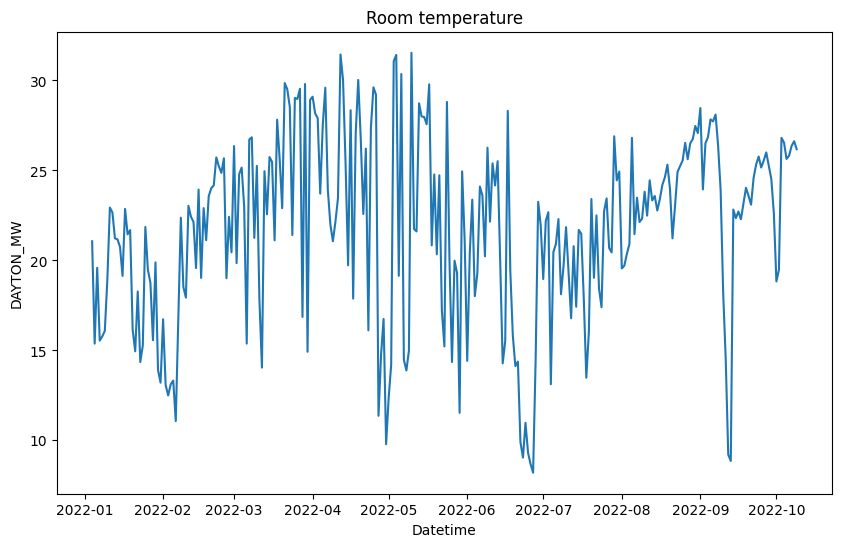

In [817]:
# How the raw data looks like in graph form aggregated by day for better results.
plt.figure(figsize=(10, 6))
sns.lineplot(dff['DAYTON_MW'])
plt.title('Room temperature')

In [818]:
# get insights on data ranges, standard deviation, and so on.
df.describe()

,Datetime1,DAYTON_MW
count,6676.000000,6676.000000
mean,11.502846,21.736007
std,6.909701,6.850502
min,0.000000,5.350000
25%,6.000000,17.512750
50%,11.000000,23.900000
75%,17.000000,26.367000
max,23.000000,36.500000


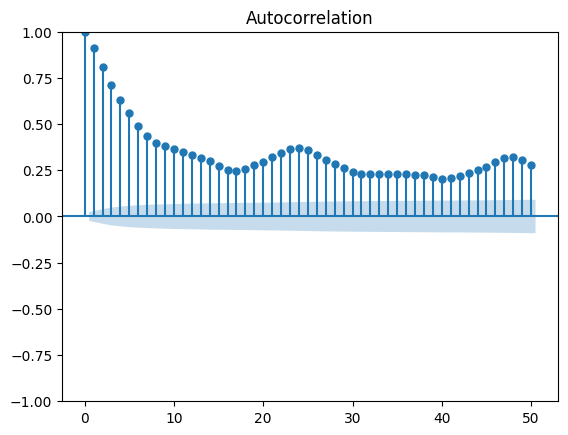

In [819]:
# help identify the degree of correlation between observations at different lags
plot_acf(df['DAYTON_MW'],lags=50)
plt.show()

<Figure size 4000x4000 with 0 Axes>

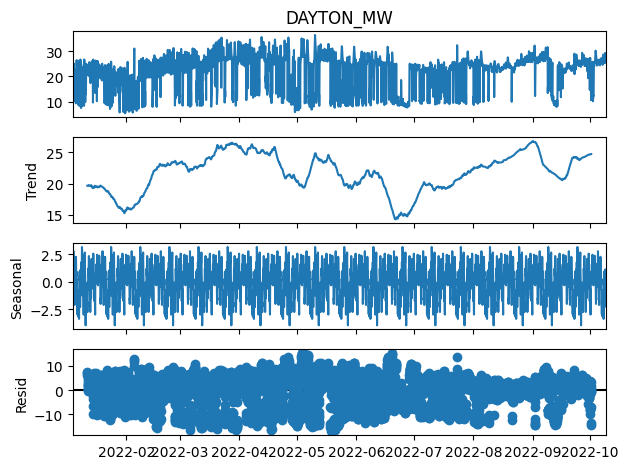

In [820]:
# No trend, but there is seasonality
result = seasonal_decompose(df['DAYTON_MW'], model='additive', period=365)
plt.figure(figsize=(40, 40), dpi=100)

result.plot()
plt.show()

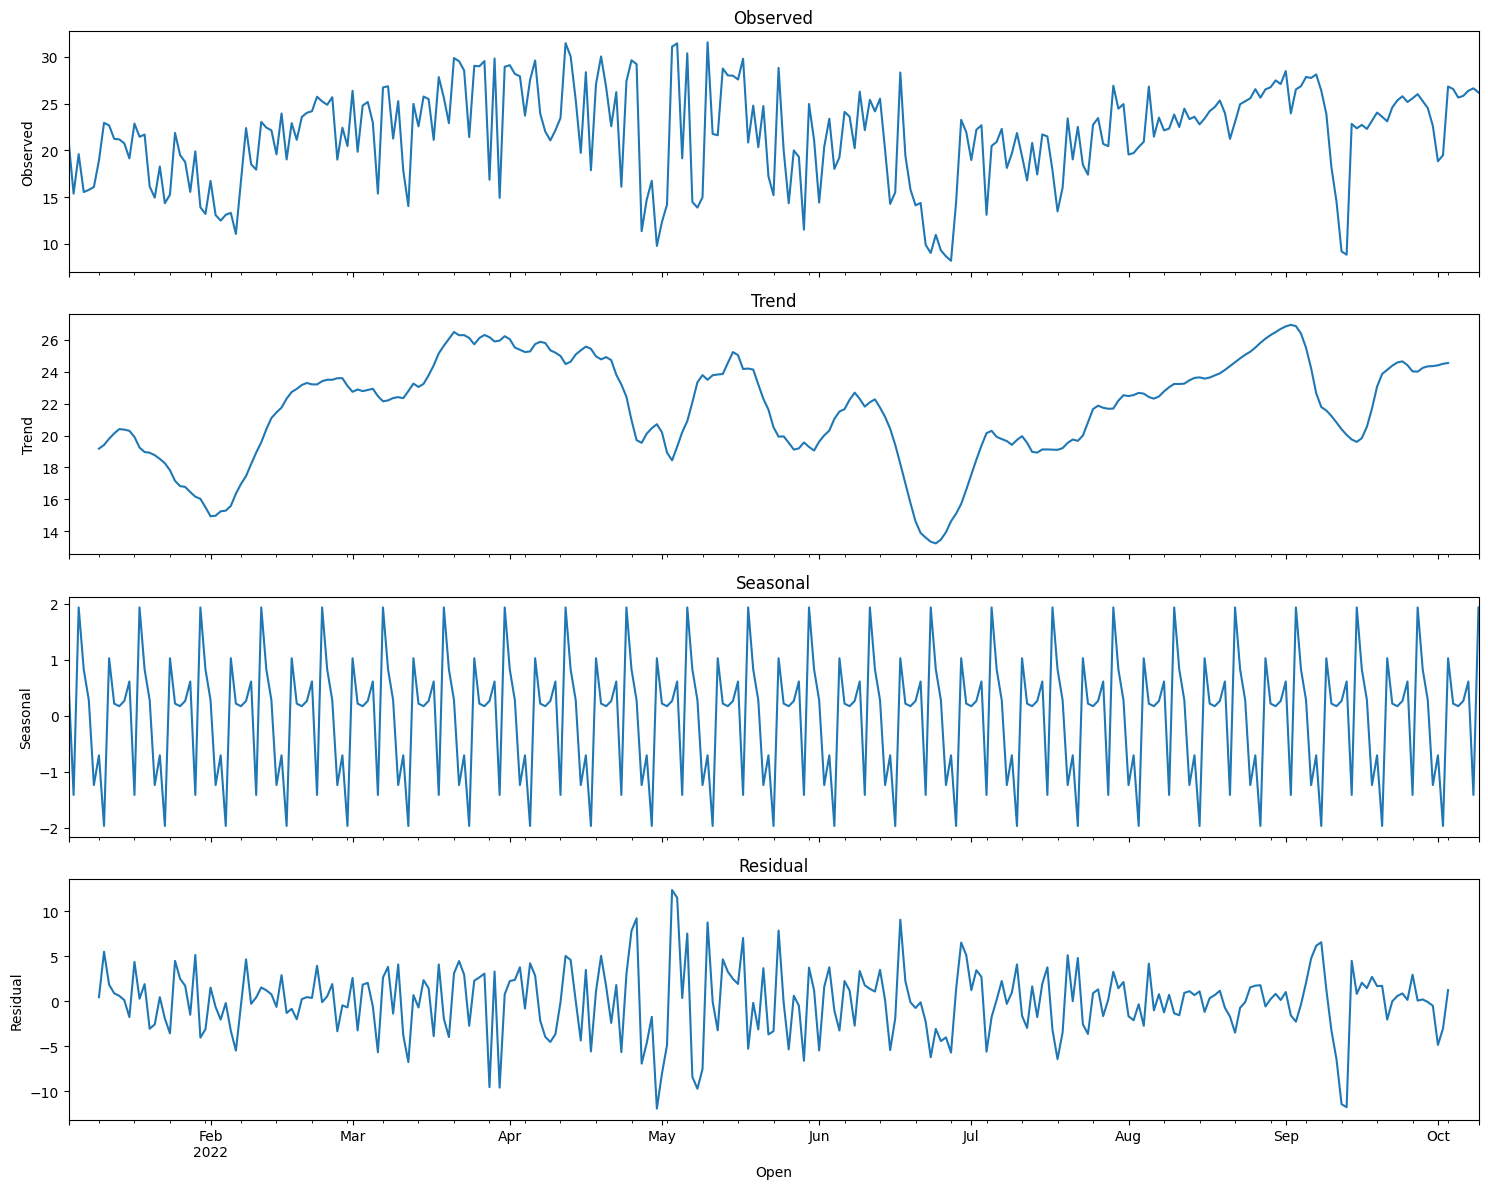

In [821]:
decomposition = seasonal_decompose(dff['DAYTON_MW'], model='multiplicative', period=12)
result = seasonal_decompose(dff['DAYTON_MW'], model='additive', period=12)
# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1, title='Observed')
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2, title='Trend')
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4, title='Residual')
ax4.set_ylabel('Residual')
ax4.set_xlabel('Open')
plt.tight_layout()
plt.show()

In [822]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dff['DAYTON_MW'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# P-Value indicates data is stationary <0.05

ADF Statistic: -3.593993
p-value: 0.005877


In [823]:
dff.isnull().sum()
# No Null values found

Datetime1    0
DAYTON_MW    0
dtype: int64

In [824]:
df.isnull().sum()
# No Null values found

Datetime1    0
DAYTON_MW    0
dtype: int64

In [825]:
has_null = df.isnull().values.any()
print(f"Are there any null values in the DataFrame? {has_null}")

Are there any null values in the DataFrame? False


In [826]:
df.corr().style.background_gradient(cmap = "Purples")

,Datetime1,DAYTON_MW
Datetime1,1.000000,-0.114513
DAYTON_MW,-0.114513,1.000000


### Split Data

In [827]:
# Drop rows with NaN values resulting from creating lag features
df.dropna(inplace=True)

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

train_df = train.reset_index()[['Datetime', 'DAYTON_MW']]
train_df.columns = ['ds', 'y']
test_df = test.reset_index()[['Datetime', 'DAYTON_MW']]
test_df.columns = ['ds', 'y']


### Model Training

In [828]:
m = Prophet(
    daily_seasonality=True, 
    weekly_seasonality=True, 
    yearly_seasonality=True,  
    seasonality_mode='additive'
)

# Fit the model with your dataframe
m.fit(train_df)

13:32:39 - cmdstanpy - INFO - Chain [1] start processing
13:32:39 - cmdstanpy - INFO - Chain [1] done processing


In [829]:
future = m.make_future_dataframe(periods=len(test), freq='H')

In [830]:
forecast = m.predict(future)

In [831]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

                      ds       yhat  yhat_lower  yhat_upper
6671 2022-10-08 23:00:00  25.436856   17.382097   33.080799
6672 2022-10-09 00:00:00  24.636932   16.931147   32.262769
6673 2022-10-09 01:00:00  23.955405   15.756942   32.286838
6674 2022-10-09 02:00:00  23.506827   15.889976   31.752604
6675 2022-10-09 03:00:00  23.205381   15.093069   31.292193


### Graphs

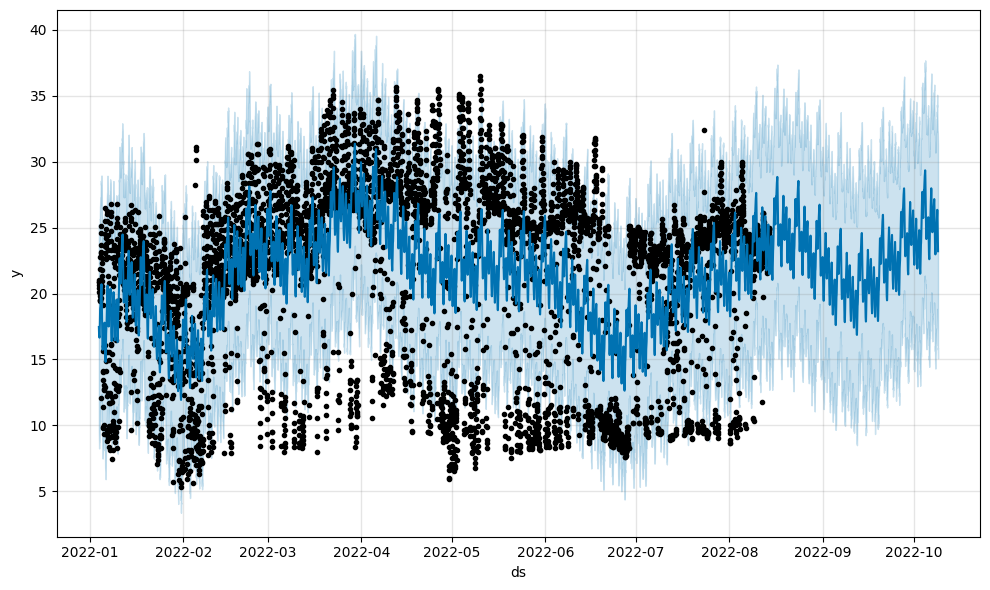

In [832]:
fig1 = m.plot(forecast)

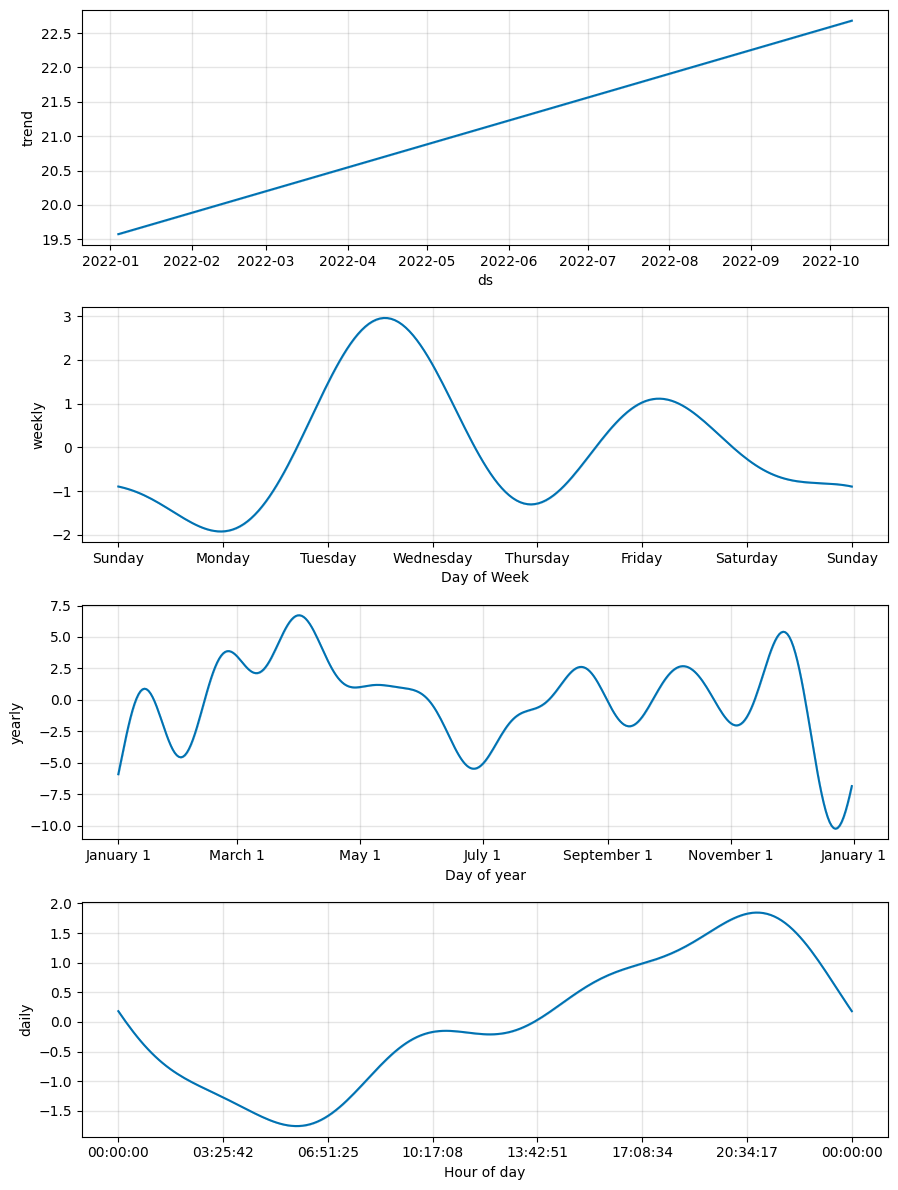

In [833]:
# More graphs genearted by prophet
fig2 = m.plot_components(forecast)

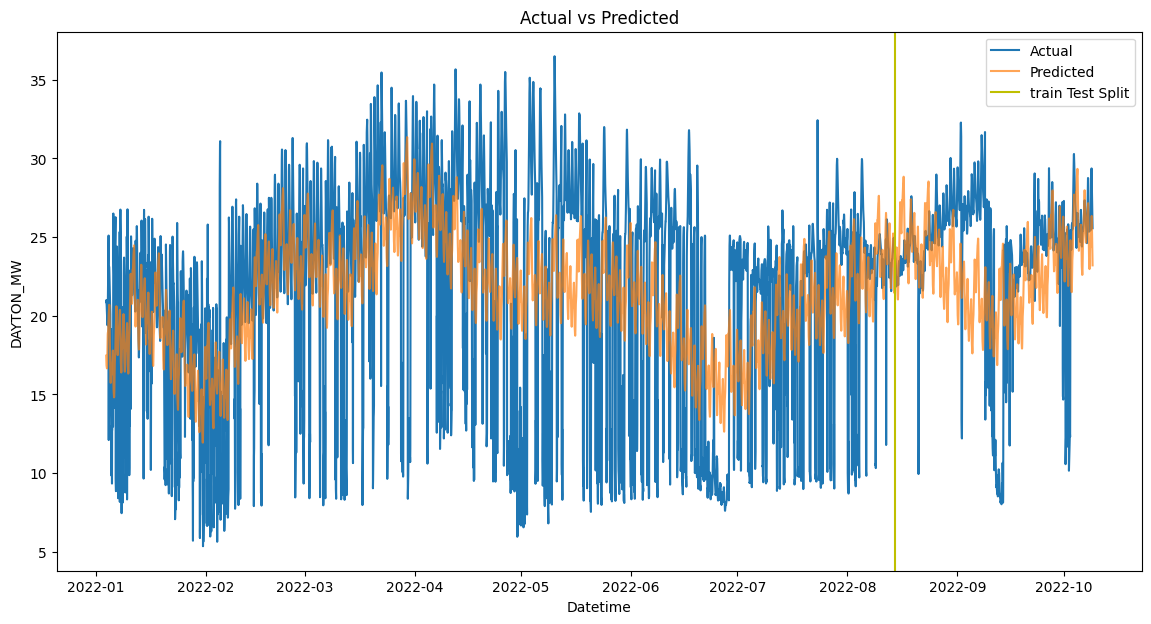

In [853]:
# graph that plots actual vs predicted with train and test data
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['DAYTON_MW'], label='Actual')
plt.plot(results.index, results['yhat'], label='Predicted', alpha=0.7)
plt.axvline(x=train.index[-1], color='y', linestyle='-', label='train Test Split')
plt.title('Actual vs Predicted')
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.legend()
plt.show()

### Yhat

In [834]:
# Check lengths
assert len(future) == len(forecast), "Lengths of future and forecast do not match!"

# Reassign 'ds' from future to forecast
forecast['ds'] = future['ds'].values  # Ensure correct alignment

# Set 'ds' as the index for forecast
forecast.set_index('ds', inplace=True)

# Verify the reassignment
print(forecast.head())
print(forecast.tail())


                         trend  yhat_lower  yhat_upper  trend_lower  \
ds                                                                    
2022-01-04 00:00:00  19.575753    9.504226   25.243528    19.575753   
2022-01-04 01:00:00  19.576218    8.841070   25.172362    19.576218   
2022-01-04 02:00:00  19.576683    8.259239   24.980605    19.576683   
2022-01-04 03:00:00  19.577148    8.656578   24.298607    19.577148   
2022-01-04 04:00:00  19.577613    9.477389   24.074278    19.577613   

                     trend_upper  additive_terms  additive_terms_lower  \
ds                                                                       
2022-01-04 00:00:00    19.575753       -2.111387             -2.111387   
2022-01-04 01:00:00    19.576218       -2.542859             -2.542859   
2022-01-04 02:00:00    19.576683       -2.745440             -2.745440   
2022-01-04 03:00:00    19.577148       -2.806392             -2.806392   
2022-01-04 04:00:00    19.577613       -2.863532          

### Error Calculations

In [835]:
# Ensure the Datetime index is set correctly in the actual data DataFrame
df.index = pd.to_datetime(df.index)

# Join actual data with forecasted data
results = df[['DAYTON_MW']].join(forecast[['yhat']], how='left')

# Calculate metrics on test data, ensuring alignment and non-NaN values
test_results = results.iloc[train_size:]  # Use your predefined train_size to slice correctly
test_results = test_results.dropna()  # Drop NaN values to ensure consistency

mae = mean_absolute_error(test_results['DAYTON_MW'], test_results['yhat'])
rmse = np.sqrt(mean_squared_error(test_results['DAYTON_MW'], test_results['yhat']))
r2 = r2_score(test_results['DAYTON_MW'], test_results['yhat'])

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')


MAE: 3.669051443438447
RMSE: 4.882670615964613
R2 Score: -0.13686070864160516


In [836]:
# Add the 'ds' column from future to forecast
forecast['ds'] = future['ds']

# Set 'ds' as the index for forecast
forecast.set_index('ds', inplace=True)
print(forecast.head())
print(forecast.tail())


         trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
ds                                                                 
NaT  19.575753    9.504226   25.243528    19.575753    19.575753   
NaT  19.576218    8.841070   25.172362    19.576218    19.576218   
NaT  19.576683    8.259239   24.980605    19.576683    19.576683   
NaT  19.577148    8.656578   24.298607    19.577148    19.577148   
NaT  19.577613    9.477389   24.074278    19.577613    19.577613   

     additive_terms  additive_terms_lower  additive_terms_upper     daily  \
ds                                                                          
NaT       -2.111387             -2.111387             -2.111387  0.181901   
NaT       -2.542859             -2.542859             -2.542859 -0.476433   
NaT       -2.745440             -2.745440             -2.745440 -0.897510   
NaT       -2.806392             -2.806392             -2.806392 -1.166977   
NaT       -2.863532             -2.863532             -2.8635

In [837]:
print(forecast.columns)


Index(['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
